#### A quick demonstration of patchy tau (amplitude modulation) reconstruction in fullsky
#### - this code shows how to compute the estiamtors, and output their power spectra

In [20]:
import numpy as np, basic, curvedsky, plottools as pl, healpy as hp
from matplotlib.pyplot import *

In [24]:
def sim(nside,cltt,Al,Il,W):
    # generate CMB alms 
    # - gaussian alms are generated, and the reconstructed cls are equal to the normalization
    Talm, Ealm, Balm = curvedsky.utils.gaussTEB(lmax,lcl[0,:],lcl[1,:],lcl[2,:],lcl[3,:])
    tlm = curvedsky.utils.gauss1alm(lmax,cltt)
    # modulate amplitude in map space
    tau  = curvedsky.utils.hp_alm2map(nside,lmax,lmax,tlm)
    Tmap = curvedsky.utils.hp_alm2map(nside,lmax,lmax,Talm)
    Talm = curvedsky.utils.hp_map2alm(nside,lmax,lmax,Tmap*np.exp(-tau)*W)
    # add noise and filtering (temp)
    Talm += curvedsky.utils.gauss1alm(lmax,nl[0,:])
    Talm *= Fl[0,:,:]
    # compute unnormalized estiamtors
    alm = {}
    alm['tTT'] = curvedsky.rec_tau.qtt(lmax,rlmin,rlmax,lcl[0,:],Talm,Talm,nside=1024)
    alm['lTT'], __ = curvedsky.rec_lens.qtt(lmax,rlmin,rlmax,lcl[0,:],Talm,Talm,nside=1024)
    # normalized estimators
    for qest in ['lTT','tTT']:
        alm[qest] *= Al[qest][:,None]
    # bhe
    alm['qTT'] = alm['tTT'] - Al['tTT'][:,None]*Al['xTT'][:,None]*alm['lTT']
    alm['qTT'] *= Il[:,None]
    # compute cross spectra
    xl = {}
    w1 = np.mean(W)
    for qest in ['qTT','tTT']:
        xl[qest] = curvedsky.utils.alm2cl(lmax,-alm[qest],tlm)/w1
    tl = curvedsky.utils.alm2cl(lmax,tlm)
    return xl['qTT'], xl['tTT'], tl

In [3]:
# define parameters
Tcmb  = 2.726e6    # CMB temperature
lmax  = 2048       # maximum multipole of output normalization
rlmin, rlmax = 100, lmax  # reconstruction multipole range
sig   = 50.
ac2rad = np.pi/180./60.
L = np.linspace(0,lmax,lmax+1)

#### load unlensed and lensed Cls

In [4]:
lcl = basic.aps.read_cambcls('../data/lensedcls.dat',2,lmax,4,bb=True)/Tcmb**2
nl  = np.zeros((4,lmax+1))
nl[0,:] = (sig*ac2rad/Tcmb)**2
nl[1,:] = 2*nl[0,:]
nl[2,:] = 2*nl[0,:]
ocl = lcl + nl

In [5]:
l, ntt = np.loadtxt('../data/Al_TT_dr2_smica_Lmask_a0.0deg_cinv_l100-2048.dat',unpack=True,usecols=(0,1))

#### calculate normalizations

In [6]:
Al = {}
Al['tTT'] = curvedsky.norm_tau.qtt(lmax,rlmin,rlmax,lcl[0,:],ocl[0,:])
#Al['tEB'] = curvedsky.norm_tau.qeb(lmax,rlmin,rlmax,lcl[1,:],ocl[1,:],ocl[2,:])

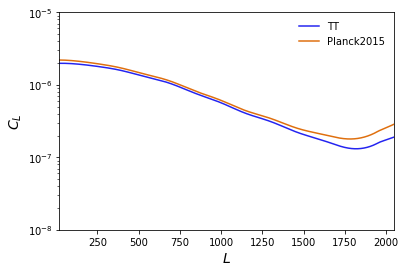

In [7]:
pl.plot_1dstyle(ylog=True,ymin=1e-8,ymax=1e-5)
plot(L,Al['tTT'],label='TT')
#plot(L,Al['tEB'],label='EB')
plot(l,ntt,label='Planck2015')
legend()

In [8]:
Al['lTT'], __ = curvedsky.norm_lens.qtt(lmax,rlmin,rlmax,lcl[0,:],ocl[0,:])
Al['xTT'] = curvedsky.norm_lens.ttt(lmax,rlmin,rlmax,lcl[0,:],ocl[0,:])
Il = 1./(1.-Al['tTT']*Al['lTT']*Al['xTT']**2)
Al['qTT'] = Al['tTT']*Il
#Al['lEB'], c = curvedsky.norm_lens.qeb(lmax,rlmin,rlmax,lcl[1,:],ocl[1,:],ocl[2,:])
#Il = 1./(1.-Al['lEB']*Al['tEB']*Al['xEB']**2)
#Al['lEB'] = Al['lEB']*Il

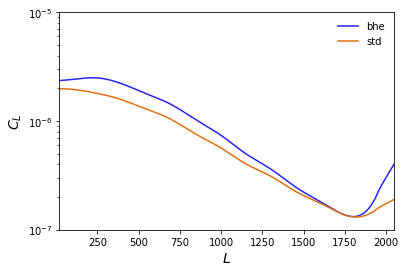

In [9]:
pl.plot_1dstyle(ylog=True,ymin=1e-7,ymax=1e-5)
plot(L,Al['qTT'],label='bhe')
plot(L,Al['tTT'],label='std')
legend()

In [10]:
# simple diagonal c-inverse
Fl = np.zeros((3,lmax+1,lmax+1))
for l in range(rlmin,rlmax):
    Fl[:,l,0:l+1] = 1./ocl[:3,l,None]

In [11]:
simn = 10
nside = 2048
cltt = 1e-3*4*np.pi/2000.**2*np.exp(-(L/2000.)**2)

In [22]:
# load mask
W = hp.fitsfunc.read_map('../data/COM_Mask_Lensing_2048_R2.00_a1.0deg.fits',verbose=False)
W = hp.ud_grade(W,nside)

In [25]:
xl = np.zeros((simn,3,lmax+1))
for i in range(simn):
    print(i)
    xl[i,:,:] = sim(nside,cltt,Al,Il,W)

0
1
2
3
4
5
6
7
8
9


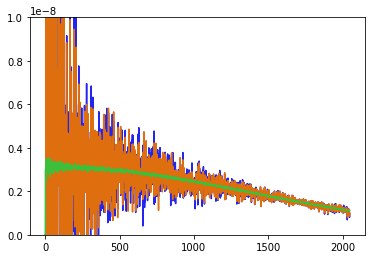

In [26]:
mxl = np.mean(xl,axis=0)
ylim(0,1e-8)
plot(mxl[0,:])
plot(mxl[1,:])
plot(mxl[2,:])

In [ ]:
#Qmap, Umap = curvedsky.utils.hp_alm2map_spin(nside,lmax,lmax,2,Ealm,Balm)
#Ealm, Balm = curvedsky.utils.hp_map2alm_spin(nside,lmax,lmax,2,Qmap*np.exp(-tau),Umap*np.exp(-tau))

In [ ]:
# add nosie and filtering (pol)
#Ealm += curvedsky.utils.gauss1alm(lmax,nl[1,:])
#Balm += curvedsky.utils.gauss1alm(lmax,nl[2,:])
#Ealm *= Fl[1,:,:]
#Balm *= Fl[2,:,:]

In [ ]:
#alm['qEB'] = curvedsky.rec_tau.qeb(lmax,rlmin,rlmax,lcl[1,:],Ealm,Balm)